In [1]:
import pickle, yaml
import pandas as pd
import numpy as np
import shap
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from sklearn import tree
from pycaret.regression import *

import src.paychex_ml.data_loader as dl

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

model_run_date = '20220512'

In [3]:
## Change the project path
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"
file_path = proyect_path+"/data/clean/table_predictable.csv"
drive_path = proyect_path+"/data/clean/table_drivers.csv"
external_path = proyect_path+"/data/external/external_data_fred.csv"
model_path = proyect_path+"/data/models/"+model_run_date

In [4]:
with open(proyect_path+"/src/line_items.yml", "r") as stream:
    items_dicctionary = yaml.safe_load(stream)

In [5]:
for key in items_dicctionary.keys():
    print (key, '--', items_dicctionary[key][0])

110 -- Total Payroll Revenue.
111 -- Payroll blended products
112 -- W-2 Revenue
113 -- Delivery Revenue
114 -- ASO Allocation
115 -- Other Processing Revenue
116 -- SurePayroll.
117 -- Total international
120 -- Total 401k
121 -- 401K Fee Revenue
122 -- 401K Asset fee & BP Revenue
130 -- Total ASO Revenue
131 -- HR Solutions [PEO]
132 -- ASO Revenue - Oasis
140 -- Total Online Services
141 -- HR Online
142 -- Time & Attendance
150 -- Other Management Solutions
151 -- Total Paychex Advance
152 -- Full Service Unemployment Revenue
153 -- ESR Revenue
154 -- Cafeteria Plans Revenue
155 -- Benetrac
156 -- Emerging Products
100 -- Management Solutions Revenue.
261 -- Total PEO
270 -- Total Insurance Services
271 -- Workers Comp - Payment Services
272 -- Health Benefits
200 -- Total PEO and Insurance Services.
300 -- Service Revenue
381 -- Interest on Funds Held for Clients
400 -- Total Revenue


In [27]:
id = '111'
target_col, has_drivers, level = items_dicctionary[id]
print("Variable to predict: ", target_col)

Variable to predict:  Payroll blended products


In [28]:
# Read the data
# df1 = pd.read_csv('C:/python/train.csv')
# df2 = pd.read_csv('C:/python/test.csv')
# data = pd.concat([df1,df2])
#print(data)

all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, level=level)
all_df = all_df[['Calendar Date', target_col]]

# Add drivers
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

# Add external data
ext_df = pd.read_csv(external_path, dtype={'date': str}) \
    .rename(columns={'date': 'Calendar Date'})
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

all_df['Calendar Date'] = pd.to_datetime(all_df['Calendar Date'])

In [29]:
# # Remove features with high null values
# data.drop(['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu','LotFrontage'], inplace=True, axis=1)
#
# # Drop null values
# data.dropna(inplace=True)
#
# # Prepare X and Y
# X = pd.get_dummies(data)
# X.drop(['SalePrice'], inplace=True, axis=1)
# print(X)
# y = data['SalePrice']

with open(model_path + '/{}_features.pkl'.format(target_col), "rb") as fp:
    feature_cols = pickle.load(fp)

keeps = ['Calendar Date', target_col]+feature_cols
all_df = all_df[keeps]

In [30]:
all_df

,Calendar Date,Payroll blended products,Product NA/6000 CORP OFFICE/# of Weeks - RW,Total Flex Blended Products Revenue/0922 DSC Central/Net Client Gain - RW,Total Preview Blended Products Revenue/0475 PHOENIX MMS/Net Client Gain - RW,Total Preview Blended Products Revenue/0482 SAN DIEGO MMS/Transfers in - RW,Total Flex Blended Products Revenue/Auburn RSC/Check Volume - RW,Total Flex Blended Products Revenue/Sarasota/SmallBiz/Check Volume - RW,Total Preview Blended Products Revenue/0434 NASHVILLE MMS/Average Check per Payroll - RW,GASREGW,Total Preview Blended Products Revenue/0476 NORTHERN NJ MMS/Chk/Client/Week - RW,PSAVERT
0,2014-06-01,99633512.0,4.0,0.0,12.0,0.0,1060433.0,69390.0,42.0,3.69160,42.0,7.1
1,2014-07-01,121619696.0,5.0,0.0,-18.0,0.0,1327526.0,85640.0,42.0,3.61125,42.0,7.2
2,2014-08-01,99472483.0,4.0,0.0,-5.0,-2.0,1071251.0,70290.0,41.0,3.48650,43.0,7.0
3,2014-09-01,94198230.0,4.0,0.0,-7.0,-1.0,1023473.0,68226.0,39.0,3.40620,41.0,7.2
4,2014-10-01,124353873.0,5.0,0.0,-9.0,-1.0,1304071.0,96398.0,42.0,3.17050,42.0,7.1
5,2014-11-01,98868618.0,4.0,0.0,0.0,0.0,1036277.0,81375.0,42.0,2.91225,42.0,7.3
6,2014-12-01,99281713.0,4.0,0.0,-2.0,0.0,1081599.0,82355.0,43.0,2.54260,46.0,7.7
7,2015-01-01,124388966.0,5.0,0.0,-63.0,0.0,1239335.0,99802.0,48.0,2.11575,45.0,8.0
8,2015-02-01,95862151.0,4.0,0.0,-3.0,0.0,984067.0,78423.0,43.0,2.21625,43.0,8.1
9,2015-03-01,92298659.0,4.0,0.0,-3.0,0.0,981805.0,76247.0,42.0,2.46360,42.0,7.7


In [34]:
model

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(display_types=False,
                                      ml_usecase='regression',
                                      numerical_features=['Product NA/6000 '
                                                          'CORP OFFICE/# of '
                                                          'Weeks - RW',
                                                          'Total Flex Blended '
                                                          'Products '
                                                          'Revenue/0922 DSC '
                                                          'Central/Net Client '
                                                          'Gain - RW',
                                                          'Total Preview '
                                                          'Blended Products '
                                                          'Revenue/0475 '
                  

In [33]:
# model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
#
# # Fit the Model
# model.fit(X, y)
model = load_model(model_path + '/{}_model'.format(target_col))

Transformation Pipeline and Model Successfully Loaded


In [36]:
X = model[:-1].transform(all_df)

In [37]:
model[-1]

ExtraTreesRegressor(n_jobs=-1, random_state=123)

In [27]:
# load JS visualization code to notebook
# shap.initjs()

In [38]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer.shap_values(X)

In [40]:
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

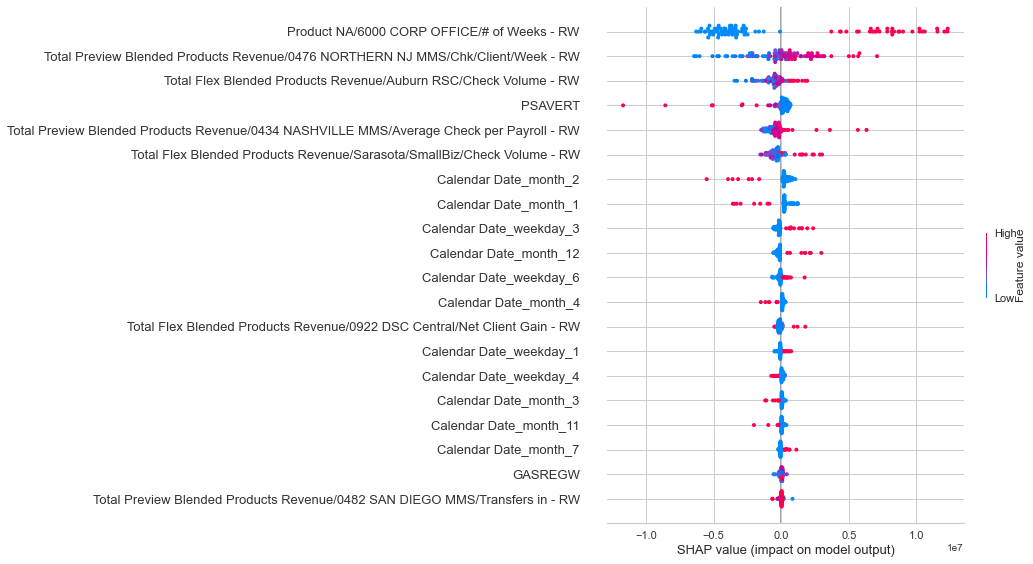

In [41]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

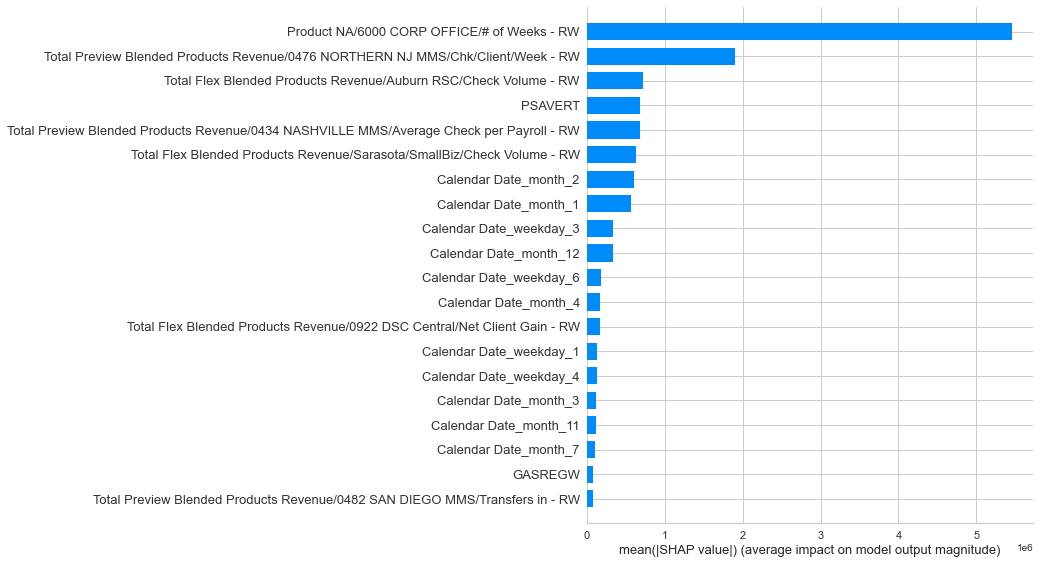

In [42]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')